# COMP-1816 Coursework

This is a coding part for the machine learning **coursework**

## California Housing

The data provided is a modified version of benchmark California housing dataset. In this task you are required to build predictive models to **predict median_house_value** and then evaluating the performance of different models.

### Data columns
- No.
- longitude, 
- latitude, 
- housing_median_age
- total_rooms
- total_bedrooms
- population
- households
- median_income
- median_house_value (this is the target label)
- ocean_proximity

## Titanic Dataset

The sinking of the Titanic is one of the most infamous shipwrecks in history. In this challenge, we ask you to build a predictive model that to predict: "what sorts of people were more likely to survive" using passenger data (name, age, geneder, socio-economic class, etc) and then evaluating the performance of different models.


## Objectives:
For each task, at least **TWO** machine learning models (one main model and at least one baseline model) are implemented. The main model is the model that you think would be most suitable for the task. You need to clarify the reason for choosing the model and describe it in detail. The baseline models are the models to be compared with the main model. The implemented models must contain one or more models that you have learned in the module COMP1816. You need to evaluate these models and analyse the reason why the main model is better/worse than the baseline models.

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, QuantileTransformer, quantile_transform, OrdinalEncoder
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVC
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, r2_score, PredictionErrorDisplay, accuracy_score, confusion_matrix, f1_score
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sn
import scipy

## Part One - **Regression**

### Helper functions

In [55]:
def compute_score(y_true, y_pred):
    return {
        "R2": f"{r2_score(y_true, y_pred):.3f}",
        "MSE": f"{mean_squared_error(y_true, y_pred):.3f}",
    }

In [56]:
def split_to_features_and_labels(file_name):
  # Firstly separate features from the labels
  data = pd.read_csv(file_name)

  features = [
      'longitude', 
      'latitude', 
      'housing_median_age', 
      'total_rooms', 
      'total_bedrooms',
      'population',
      'households',
      'median_income',
      'ocean_proximity'
  ]

  X = data[features]
  y = data['median_house_value']

  return [X, y]

In [57]:
def show_numerical_stats(df, feature_label):
  series = X_train_raw[feature_label]

  print("min value: ", series.min())
  print("max value: ", series.max())
  print("Numbrt of null entries: ", series.isnull().sum())

  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

  series.plot.hist(ax=axs[0], bins=50)
  axs[0].set_title(f'Histogram of {feature_label}')

  series.plot.box(ax=axs[1])
  axs[1].set_title(f'Boxplot of {feature_label}')

  plt.show()

In [58]:
def show_target_analysis(series):
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

  series.plot.hist(ax=axs[0], bins=100)
  axs[0].set_title("Histogram of target values")

  series.plot.box(ax=axs[1])
  axs[1].set_title("Boxplot of target values")

In [59]:
# Plot the probability density functionns of the target before and after apllying logarithmic function and Quantile function
def show_target_density(target_data):
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))

  axs[0].hist(target_data, bins=100, density=True)
  axs[0].set_ylabel("Probability")
  axs[0].set_xlabel("Target")
  axs[0].set_title("Target distribution")

  axs[1].hist(np.log1p(target_data), bins=100, density=True)
  axs[1].set_ylabel("Probability")
  axs[1].set_xlabel("Target")
  axs[1].set_title("Transformed target distribution with the use of logarithmic function")

  axs[2].hist(quantile_transform(target_data.to_frame(), n_quantiles=900, output_distribution="normal", copy=True), bins=100, density=True)
  axs[2].set_ylabel("Probability")
  axs[2].set_xlabel("Target")
  axs[2].set_title("Transformed target distribution with the use of quantile transform")

In [60]:
def impute_data(X_train, X_test):
  """ 
  I will use mean of the values from the column where the data is missing and
  then fill that missing values with the mean.
  """

  total_bedrooms_mean = float(int(X_train["total_bedrooms"].mean()))

  # Use the mean to fill all empty values from that column with the mean value
  X_train['total_bedrooms'] = X_train['total_bedrooms'].fillna(total_bedrooms_mean)
  X_test['total_bedrooms'] = X_test['total_bedrooms'].fillna(total_bedrooms_mean)

  return X_train, X_test

In [61]:
def preprocess_data(X_train, X_test, drop_cols=None):

  # Firstly impute data
  X_train_inputed, X_test_inputed = impute_data(X_train, X_test)

  if drop_cols is not None:
    X_train_inputed = X_train_inputed.drop(columns=drop_cols)
    X_test_inputed = X_test_inputed.drop(columns=drop_cols)
  

  # Firstly separate categorical features from numerical features
  X_train_numerical = X_train_inputed.select_dtypes(include=np.number)
  X_test_numerical = X_test_inputed.select_dtypes(include=np.number)
  
  X_train_categorical = X_train_inputed.select_dtypes(exclude=np.number)
  X_test_categorical = X_test_inputed.select_dtypes(exclude=np.number)

  # Standardise dataset
  numerical_feature_scaler = StandardScaler().fit(X_train_numerical)

  X_train_numerical_standardised = numerical_feature_scaler.transform(X_train_numerical)
  X_test_numerical_standardised = numerical_feature_scaler.transform(X_test_numerical)

  # Apply One-Hot encoding to categorical features
  categorical_encoder = OneHotEncoder().fit(X_train_categorical)

  X_train_categorical_encoded = categorical_encoder.transform(X_train_categorical)
  X_test_categorical_encoded = categorical_encoder.transform(X_test_categorical)

  # Merge categorical and numerical data
  X_train = np.hstack([X_train_numerical_standardised, X_train_categorical_encoded.toarray()])
  X_test = np.hstack([X_test_numerical_standardised, X_test_categorical_encoded.toarray()])

  return X_train, X_test

### Firstly load the data and perform the analysis

In [63]:
data = pd.read_csv('./housing_coursework_train.csv')
X_train_raw, y_train = split_to_features_and_labels("./housing_coursework_train.csv")
X_test_raw, y_test = split_to_features_and_labels("./housing_coursework_test.csv")

### Data overview

#### General overview

In [64]:
display(X_train_raw)
X_train_raw.info()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-122.21,37.83,34,5065,788.0,1627,766,6.8976,NEAR BAY
1,-122.22,37.77,52,391,128.0,520,138,1.6471,NEAR BAY
2,-122.23,37.79,30,610,145.0,425,140,1.6198,NEAR BAY
3,-122.20,37.78,52,2300,443.0,1225,423,3.5398,NEAR BAY
4,-122.19,37.79,50,954,217.0,546,201,2.6667,NEAR BAY
...,...,...,...,...,...,...,...,...,...
795,-122.55,37.79,32,2131,625.0,1229,572,2.9201,NEAR OCEAN
796,-121.29,37.96,52,287,119.0,154,85,0.8738,INLAND
797,-121.32,37.97,46,2270,427.0,1097,453,3.3235,INLAND
798,-121.29,37.97,52,2995,555.0,1392,503,1.7794,INLAND


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           800 non-null    float64
 1   latitude            800 non-null    float64
 2   housing_median_age  800 non-null    int64  
 3   total_rooms         800 non-null    int64  
 4   total_bedrooms      792 non-null    float64
 5   population          800 non-null    int64  
 6   households          800 non-null    int64  
 7   median_income       800 non-null    float64
 8   ocean_proximity     800 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 56.4+ KB


<AxesSubplot:>

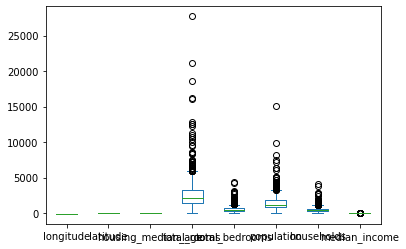

In [65]:
X_train_raw.select_dtypes(include=np.number).plot.box()

In [66]:
display(X_test_raw)
X_test_raw.info()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-121.26,37.93,33,2109,531.0,2248,588,1.4583,INLAND
1,-121.28,37.94,40,2806,685.0,2268,635,1.8814,INLAND
2,-121.24,37.98,33,450,123.0,236,103,1.1964,INLAND
3,-121.23,37.96,44,2204,473.0,1277,435,1.5539,INLAND
4,-121.33,38.00,32,4474,929.0,2177,884,3.2889,INLAND
...,...,...,...,...,...,...,...,...,...
215,-121.70,38.65,22,1360,282.0,808,229,2.4167,INLAND
216,-121.92,38.57,10,1320,246.0,898,228,1.9327,INLAND
217,-122.00,38.83,26,272,49.0,194,52,3.4187,INLAND
218,-122.03,38.69,23,1796,380.0,939,330,2.7955,INLAND


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           220 non-null    float64
 1   latitude            220 non-null    float64
 2   housing_median_age  220 non-null    int64  
 3   total_rooms         220 non-null    int64  
 4   total_bedrooms      219 non-null    float64
 5   population          220 non-null    int64  
 6   households          220 non-null    int64  
 7   median_income       220 non-null    float64
 8   ocean_proximity     220 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 15.6+ KB


There are 800 entries and 11 columns in total. One column is devoted to the label and one column is for ordering. Therefore there are 9 features in this dataset.

One feature (**ocean_proximity**) is categorical encoded as strings. It must be changed to integer or perform encoding.

Most of the features are non-null and the total_bedrooms is the only exception. To address this issue I will use mean value of total_bedrooms and assign it to the empty fields

Data also has to be normalised excluding categorical values and labels

#### Evaluate data column separately

##### Longitude (numerical)

In [ ]:
show_numerical_stats(X_train_raw, "longitude")

##### Latitude (Numerical)

In [ ]:
show_numerical_stats(X_train_raw, "latitude")

##### Housing median age (numerical)

In [ ]:
show_numerical_stats(X_train_raw, "housing_median_age")

##### Total rooms (numerical)

In [ ]:
show_numerical_stats(X_train_raw, "total_rooms")

This column has a lot of outliers on the right side. 

##### Total bedrooms (numerical)

In [ ]:
show_numerical_stats(X_train_raw, "total_bedrooms")

##### Population (numerical)

In [ ]:
show_numerical_stats(X_train_raw, "population")

There are a outliers in case of populations too!

##### Households

In [ ]:
show_numerical_stats(X_train_raw, "households")

##### median_income (numerical)

In [ ]:
show_numerical_stats(X_train_raw, "median_income")

##### Ocean proximity (Categorical Value)

In [ ]:
print("Unique values: ", X_train_raw["ocean_proximity"].unique())

#### Analysis of target values

In [ ]:
# Create a histogram and boxplot for y_train data
show_target_analysis(y_train)

In [ ]:
# Visualise X training data without outliers
show_target_analysis(y_train.drop(y_train.index[y_train > 450000], axis=0))

In [ ]:
show_target_density(y_train)
show_target_density(y_train_without_outliers)

#### Variance and Corellation
Now I will evaulate the features. Perhaps there are some redundant features that can be removed.

In [71]:
X_train_raw.var()

<ipython-input-71-8eb5d6a233c4>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  X_train_raw.var()


longitude             3.505214e+00
latitude              4.184249e+00
housing_median_age    1.558077e+02
total_rooms           5.134004e+06
total_bedrooms        1.945108e+05
population            1.300433e+06
households            1.562527e+05
median_income         3.627552e+00
dtype: float64

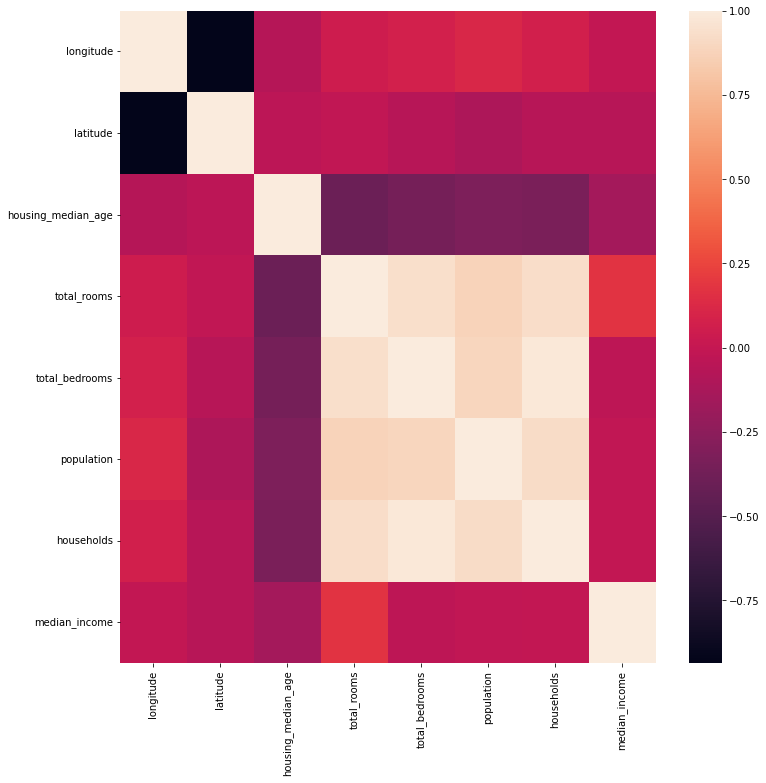

In [68]:
fig, ax = plt.subplots(figsize=(12, 12))
sn.heatmap(X_train_raw.corr(), ax=ax)
plt.show() 

In [70]:
# Display correlation between every feature and target
for feature in X_train_raw.select_dtypes(include=np.number):
  print('{}: {:.4f}'.format(
      feature, 
      abs(y_train.corr(X_train_raw[feature]))
  ))

longitude: 0.0001
latitude: 0.1706
housing_median_age: 0.1350
total_rooms: 0.0888
total_bedrooms: 0.0109
population: 0.0469
households: 0.0335
median_income: 0.6505


After evaluating correlation between particular features, I decided to remove total_bedrooms feature as its corellation to the target value is smaller than corellation between target value and total_rooms. At the same time correlation between total_rooms and total_bedrooms is high. So total_rooms represents total_bedrooms.

### Data Pre-processing

In [69]:
X_train_without_outliers = X_train_raw.drop(X_train_raw.index[y_train > 500000], axis=0)
y_train_without_outliers = y_train.drop(y_train.index[y_train > 500000], axis=0)

In [72]:
features_to_drop = ["total_rooms"]

X_train, X_test = preprocess_data(X_train_raw, X_test_raw, drop_cols=features_to_drop)
X_train_without_outliers, X_test_without_outliers = preprocess_data(X_train_without_outliers, X_test_raw, drop_cols=features_to_drop)

### Fitting the model

As the baseline model I am going to use:
- Linear Regression
- SVM

And as a main model I am going to use **RidgeCV**.

#### Linear Regression

##### Linear Regression With Outliers

In [73]:
linear_regression_pure = LinearRegression()
linear_regression_pure.fit(X_train, y_train)

linear_regression_transformed = TransformedTargetRegressor(
    regressor=LinearRegression(),
    transformer=QuantileTransformer(n_quantiles=900, output_distribution="normal")
)
linear_regression_transformed.fit(X_train, y_train)

y_train_pred = linear_regression_pure.predict(X_train)
y_test_pred = linear_regression_pure.predict(X_test)

y_train_pred_with_trans_target = linear_regression_transformed.predict(X_train)
y_test_pred_with_trans_target = linear_regression_transformed.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (900) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  warnings.warn(


Evaluation of Linear Regression model: 
4644797466.411
0.618
Evaluation of Linear Regression model with transformed target: 
5171975116.182
0.575


Text(0.5, 1.0, 'Linear regression \n with target transformation')

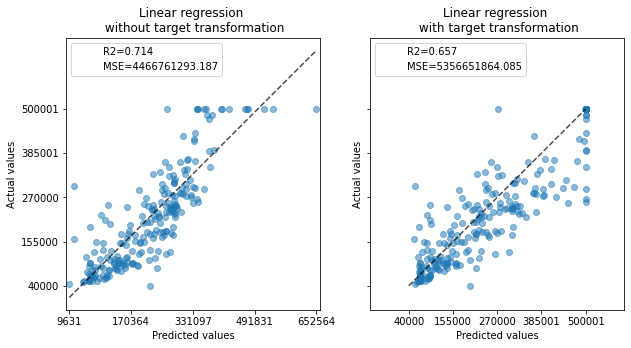

In [74]:
train_score_pure = compute_score(y_train, y_train_pred)
print('Evaluation of Linear Regression model: ')
print(train_score_pure['MSE'] + '\n' + train_score_pure['R2'])

train_score_transformed = compute_score(y_train, y_train_pred_with_trans_target)
print('Evaluation of Linear Regression model with transformed target: ')
print(train_score_transformed['MSE'] + '\n' + train_score_transformed['R2'])

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

PredictionErrorDisplay.from_predictions(
    y_test,
    y_test_pred,
    kind="actual_vs_predicted",
    ax=axs[0],
    scatter_kwargs={"alpha": 0.5}
)

PredictionErrorDisplay.from_predictions(
    y_test,
    y_test_pred_with_trans_target,
    kind="actual_vs_predicted",
    ax=axs[1],
    scatter_kwargs={"alpha": 0.5}
)

# Add the score in the legend of each axis
for ax, y_pred in zip(axs, [y_test_pred, y_test_pred_with_trans_target]):
    for name, score in compute_score(y_test, y_pred).items():
        ax.plot([], [], " ", label=f"{name}={score}")
    ax.legend(loc="upper left")

axs[0].set_title("Linear regression \n without target transformation")
axs[1].set_title("Linear regression \n with target transformation")

##### Linear Regression without outliers

In [75]:
linear_regression_pure = LinearRegression()
linear_regression_pure.fit(X_train_without_outliers, y_train_without_outliers)

linear_regression_transformed = TransformedTargetRegressor(
    regressor=LinearRegression(),
    transformer=QuantileTransformer(n_quantiles=900, output_distribution="normal")
)
linear_regression_transformed.fit(X_train_without_outliers, y_train_without_outliers)

y_train_pred = linear_regression_pure.predict(X_train_without_outliers)
y_test_pred = linear_regression_pure.predict(X_test)

y_train_pred_with_trans_target = linear_regression_transformed.predict(X_train_without_outliers)
y_test_pred_with_trans_target = linear_regression_transformed.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (900) is greater than the total number of samples (768). n_quantiles is set to n_samples.
  warnings.warn(


Evaluation of Linear Regression model: 
3860025432.988
0.566
Evaluation of Linear Regression model with transformed target: 
3903868215.633
0.561


Text(0.5, 1.0, 'Linear regression \n with target transformation')

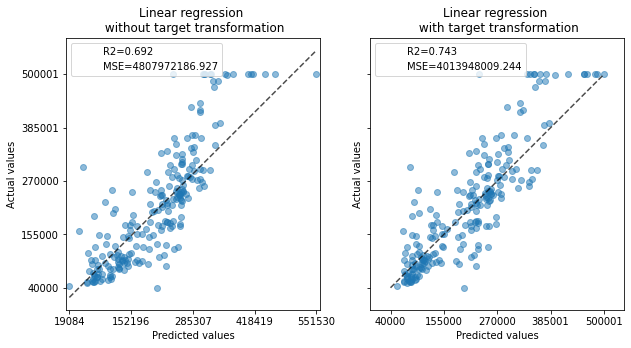

In [76]:
train_score_pure = compute_score(y_train_without_outliers, y_train_pred)
print('Evaluation of Linear Regression model: ')
print(train_score_pure['MSE'] + '\n' + train_score_pure['R2'])

train_score_transformed = compute_score(y_train_without_outliers, y_train_pred_with_trans_target)
print('Evaluation of Linear Regression model with transformed target: ')
print(train_score_transformed['MSE'] + '\n' + train_score_transformed['R2'])

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

PredictionErrorDisplay.from_predictions(
    y_test,
    y_test_pred,
    kind="actual_vs_predicted",
    ax=axs[0],
    scatter_kwargs={"alpha": 0.5}
)

PredictionErrorDisplay.from_predictions(
    y_test,
    y_test_pred_with_trans_target,
    kind="actual_vs_predicted",
    ax=axs[1],
    scatter_kwargs={"alpha": 0.5}
)

# Add the score in the legend of each axis
for ax, y_pred in zip(axs, [y_test_pred, y_test_pred_with_trans_target]):
    for name, score in compute_score(y_test, y_pred).items():
        ax.plot([], [], " ", label=f"{name}={score}")
    ax.legend(loc="upper left")

axs[0].set_title("Linear regression \n without target transformation")
axs[1].set_title("Linear regression \n with target transformation")

#### Ridge Regressor

##### Ridge Regressor with outliers

In [77]:
ridge_pure = Ridge(alpha=1)
ridge_pure.fit(X_train, y_train)

ridge_transformed = TransformedTargetRegressor(
    regressor=Ridge(alpha=1),
    transformer=QuantileTransformer(n_quantiles=900, output_distribution="normal")
)
ridge_transformed.fit(X_train, y_train)

y_train_pred = ridge_pure.predict(X_train)
y_test_pred = ridge_pure.predict(X_test)

y_train_pred_with_trans_target = ridge_transformed.predict(X_train)
y_test_pred_with_trans_target = ridge_transformed.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (900) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  warnings.warn(


In [ ]:
train_score_pure = compute_score(y_train, y_train_pred)
print('Evaluation of pure RidgeCV model: ')
print(train_score_pure['MSE'] + '\n' + train_score_pure['R2'])

train_score_transformed = compute_score(y_train, y_train_pred_with_trans_target)
print('Evaluation of RidgeCV model with target value transformed: ')
print(train_score_transformed['MSE'] + '\n' + train_score_transformed['R2'])

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

PredictionErrorDisplay.from_predictions(
    y_test,
    y_test_pred,
    kind="actual_vs_predicted",
    ax=axs[0],
    scatter_kwargs={"alpha": 0.5}
)

PredictionErrorDisplay.from_predictions(
    y_test,
    y_test_pred_with_trans_target,
    kind="actual_vs_predicted",
    ax=axs[1],
    scatter_kwargs={"alpha": 0.5}
)

# Add the score in the legend of each axis
for ax, y_pred in zip(axs, [y_test_pred, y_test_pred_with_trans_target]):
    for name, score in compute_score(y_test, y_pred).items():
        ax.plot([], [], " ", label=f"{name}={score}")
    ax.legend(loc="upper left")

axs[0].set_title("Ridge \n without target transformation")
axs[1].set_title("Ridge \n with target transformation")

##### Ridge Regressor without outliers

In [85]:
ridge_pure = Ridge(alpha=0.0)
ridge_pure.fit(X_train_without_outliers, y_train_without_outliers)

ridge_transformed = TransformedTargetRegressor(
    regressor=Ridge(alpha=0.0),
    transformer=QuantileTransformer(n_quantiles=900, output_distribution="normal")
)
ridge_transformed.fit(X_train_without_outliers, y_train_without_outliers)

y_train_pred = ridge_pure.predict(X_train_without_outliers)
y_test_pred = ridge_pure.predict(X_test)

y_train_pred_with_trans_target = ridge_transformed.predict(X_train_without_outliers)
y_test_pred_with_trans_target = ridge_transformed.predict(X_test)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.92206e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_data.py:2627: UserWarning: n_quantiles (900) is greater than the total number of samples (768). n_quantiles is set to n_samples.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.92206e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Evaluation of pure RidgeCV model: 
3860025432.988
0.566
Evaluation of RidgeCV model with target value transformed: 
3903868215.633
0.561


Text(0.5, 1.0, 'Ridge \n with target transformation')

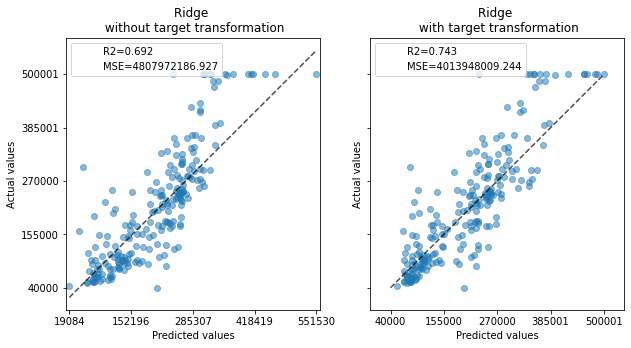

In [86]:
train_score_pure = compute_score(y_train_without_outliers, y_train_pred)
print('Evaluation of pure RidgeCV model: ')
print(train_score_pure['MSE'] + '\n' + train_score_pure['R2'])

train_score_transformed = compute_score(y_train_without_outliers, y_train_pred_with_trans_target)
print('Evaluation of RidgeCV model with target value transformed: ')
print(train_score_transformed['MSE'] + '\n' + train_score_transformed['R2'])

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

PredictionErrorDisplay.from_predictions(
    y_test,
    y_test_pred,
    kind="actual_vs_predicted",
    ax=axs[0],
    scatter_kwargs={"alpha": 0.5}
)

PredictionErrorDisplay.from_predictions(
    y_test,
    y_test_pred_with_trans_target,
    kind="actual_vs_predicted",
    ax=axs[1],
    scatter_kwargs={"alpha": 0.5}
)

# Add the score in the legend of each axis
for ax, y_pred in zip(axs, [y_test_pred, y_test_pred_with_trans_target]):
    for name, score in compute_score(y_test, y_pred).items():
        ax.plot([], [], " ", label=f"{name}={score}")
    ax.legend(loc="upper left")

axs[0].set_title("Ridge \n without target transformation")
axs[1].set_title("Ridge \n with target transformation")

## Part two - Classification

### Helper functions

In [3]:
def load_data(file_name, drop_columns = None):
  df = pd.read_csv(file_name)

  features = ["Pclass", "Name", "Sex", "Age", "SibSp", "Parch", "Ticket", "Fare", "Embarked"]

  if drop_columns is not None:
    features = list(filter(lambda x: x in drop_columns, features))

  X = df[features]
  y = df["Target: Survived"]

  return X, y

In [4]:
def show_numerical_stats(df, feature_label):
  series = X_train_raw[feature_label]

  print("min value: ", series.min())
  print("max value: ", series.max())
  print("Numbrt of null entries: ", series.isnull().sum())

  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

  series.plot.hist(ax=axs[0], bins=50)
  axs[0].set_title(f'Histogram of {feature_label}')

  series.plot.box(ax=axs[1])
  axs[1].set_title(f'Boxplot of {feature_label}')

  plt.show()

### Load the data

In [32]:
# Load raw data
X_train_raw, y_train = load_data("./Titanic_train.csv")
X_test_raw, y_test = load_data("./Titanic_test.csv")

X_train_raw.info()
X_test_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    650 non-null    int64  
 1   Name      650 non-null    object 
 2   Sex       650 non-null    object 
 3   Age       514 non-null    float64
 4   SibSp     650 non-null    int64  
 5   Parch     650 non-null    int64  
 6   Ticket    650 non-null    object 
 7   Fare      650 non-null    float64
 8   Embarked  649 non-null    object 
dtypes: float64(2), int64(3), object(4)
memory usage: 45.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    241 non-null    int64  
 1   Name      241 non-null    object 
 2   Sex       241 non-null    object 
 3   Age       200 non-null    float64
 4   SibSp     241 non-null    int64  
 5   Parch     241 non-null

### Analysis

#### Basic analysis

There are 11 columns in which 1 column is only for the ordering purposes (PassengerId), and one column is the target value for each row (Target: Survived). Therefore, there are 9 features.

**Age** column has 136 missing values, and **Embarked** has one missing value which must be imputed. 

Features description
**Pclass** - Ticket class - Categorical: 1 = 1st class, 2 = 2nd class, 3 = 3rd class

**Name** - Passanger's name - text data

**Sex** - sex of the particular passanger - Categorical: male, female

**Age** - age of a passanger - Continuous value

**SibSp** - number of siblings / spouses aboard the Titanic

**Parch** - Number of parent / children aboard the Titanic

**Ticket** - Ticket number - String value

**Fare** - Passenger fare - Continuous value

**embarked** - Port of Embarkation - Categorical value: C = Cherbourg, Q=Queenstown, S=Southampton

#### Additional analysis
Because Name, and Ticket are unique values for every passenger (sometimes names may occure more than once, but it must be a coincidence) they should not be taken into account as they don't correlate with the survival rate.

Additional analysis is also performed by checking the variance and correlation between the features

In [33]:
X_train_raw.var()

<ipython-input-33-8eb5d6a233c4>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  X_train_raw.var()


Pclass       0.700839
Age        214.309706
SibSp        1.158222
Parch        0.646554
Fare      2032.913695
dtype: float64

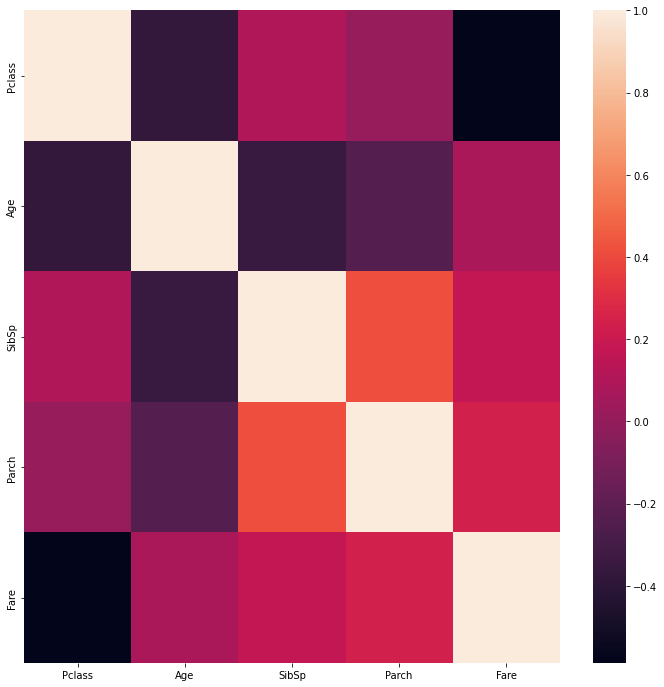

In [34]:
fig, ax = plt.subplots(figsize=(12, 12))
sn.heatmap(X_train_raw.corr(), ax=ax)
plt.show()

Drop candidates:
- PassengerId
- Name
- Ticket

#### Target Value Analysis

In [54]:
print("unique values: ", y_train.unique())

unique values:  [0 1]


#### Analysis of each feature separately

In [7]:
def show_categorical_analysis(df, feature, bins=10):
  print("Unique values: ", df[feature].unique())
  print("Number of null values: ", df[feature].isnull().sum())

  # plot the histogram with the mode value marked
  df[feature].plot.hist(bins=bins)
  plt.show()

##### Check Pclass column (Categorical)

Unique values:  [3 1 2]
Number of null values:  0


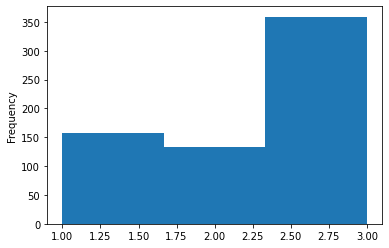

In [8]:
show_categorical_analysis(X_train_raw, "Pclass", bins=3)

##### Check Name (Categorical)

In [9]:
name_series = X_train_raw["Name"]
print(len(name_series.unique()))
print(name_series.isnull().sum())

650
0


There are 650 unique names

##### Check Sex (Categorical)

In [10]:
sex_series = X_train_raw["Sex"]
print(sex_series.unique())
print(sex_series.isnull().sum())

print(sex_series.mode())

['male' 'female']
0
0    male
dtype: object


##### Check Age (Numerical)

min value:  0.75
max value:  82.69879743589743
Numbrt of null entries:  0


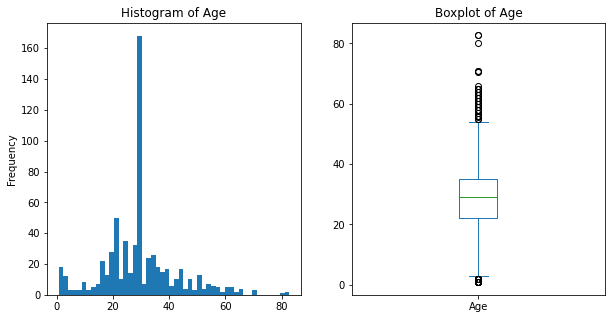

0      2
1      2
2      2
3      2
4      2
      ..
645    2
646    2
647    3
648    2
649    2
Name: Age, Length: 650, dtype: category
Categories (3, int64): [1 < 2 < 3]

In [ ]:
show_numerical_stats(X_train_raw, "Age")

interval_age = pd.cut(X_train_raw["Age"], bins=[0, 18, 50, 90], labels=[1, 2, 3])

display(interval_age)

Maybe it is worth to create the age groups?

##### Check SibSp (Numerical)

min value:  0
max value:  8
Numbrt of null entries:  0


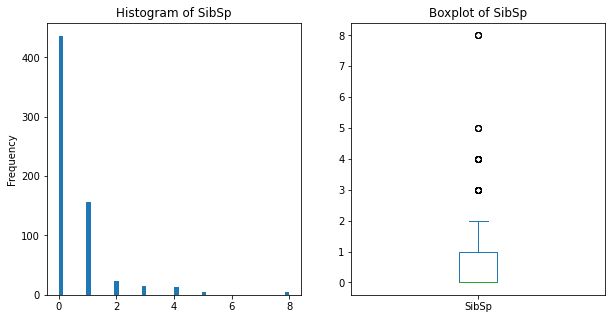

In [ ]:
show_numerical_stats(X_train_raw, "SibSp")

##### Check Parch (Numerical)

min value:  0
max value:  5
Numbrt of null entries:  0


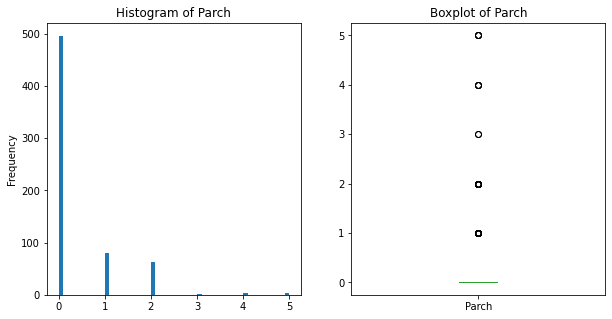

In [ ]:
show_numerical_stats(X_train_raw, "Parch")

##### Check Ticket (Categorical)

In [ ]:
ticket_series = X_train_raw["Ticket"]
print(len(ticket_series.unique()))
print(ticket_series.isnull().sum())

524
0


##### Check Fare (Numerical)

min value:  0.0
max value:  512.3292
Numbrt of null entries:  0


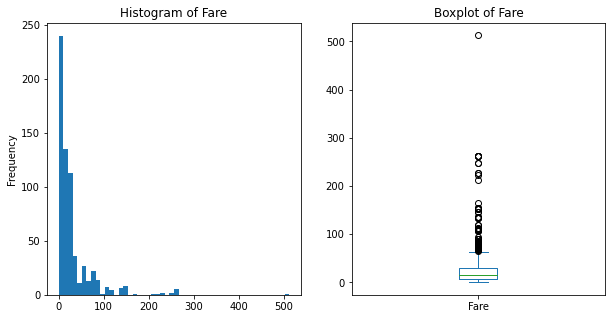

In [ ]:
show_numerical_stats(X_train_raw, "Fare")

There are entries with Fare equal to 0, which means that those passengers did not pay for the ticket. There are also outliers including one with the vlaue of 512.

In [ ]:
display(X_train_raw[X_train_raw["Fare"] == 0])
display(X_train_raw[X_train_raw["Fare"] > 150])

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
179,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,S
263,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,S
271,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,S
277,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,S
302,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,S
413,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,S
466,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,S
481,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,S
597,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,S
633,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,S


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
27,1,"Fortune, Mr. Charles Alexander",male,19.00,3,2,19950,263.0000,S
88,1,"Fortune, Miss. Mabel Helen",female,23.00,3,2,19950,263.0000,S
118,1,"Baxter, Mr. Quigg Edmond",male,24.00,0,1,PC 17558,247.5208,C
258,1,"Ward, Miss. Anna",female,35.00,0,0,PC 17755,512.3292,C
268,1,"Graham, Mrs. William Thompson (Edith Junkins)",female,58.00,0,1,PC 17582,153.4625,S
297,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,S
299,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.00,0,1,PC 17558,247.5208,C
305,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,S
311,1,"Ryerson, Miss. Emily Borie",female,18.00,2,2,PC 17608,262.3750,C
318,1,"Wick, Miss. Mary Natalie",female,31.00,0,2,36928,164.8667,S


What to do with these outliers?

##### Check Embarked (Categorical)

In [ ]:
embarked_series = X_train_raw["Embarked"]
print(embarked_series.unique())
print(embarked_series.isnull().sum())

['S' 'C' 'Q' nan]
1


### Data Preprocessing

In [16]:
def impute_data(X_train, X_test, feature, numerical):
  """ 
  I will use mean of the values from the column where the data is missing and
  then fill that missing values with the mean.
  """

  if numerical:
    to_fill = float(int(X_train[feature].mean()))
  else:
    to_fill = X_train[feature].mode()[0]

  # Use the mean to fill all empty values from that column with the mean value
  X_train[feature] = X_train[feature].fillna(to_fill)
  X_test[feature] = X_test[feature].fillna(to_fill)

  return X_train, X_test

In [15]:
def encode_data(X, Encoder):
  # Get textual data
  X_categorical = X.select_dtypes(exclude=np.number)

  # Encode data using given Encoder
  X_categorical_encoded = Encoder().fit_transform(X_categorical)

  encoded_df = pd.DataFrame()
  encoded_df["Sex"] = X_categorical_encoded[:, 0]
  encoded_df["Embarked"] = X_categorical_encoded[:, 1]

  # Convert numerical age values into categorical values
  encoded_df["Age"] = pd.cut(X["Age"], bins=[0, 18, 50, 90], labels=[1, 2, 3])
  encoded_df["Pclass"] = X["Pclass"]
  return encoded_df

In [14]:
def standardise_data(X):
  # Use standard Scaler for the fare, SibSp, Parch.
  X_numerical_standardised = StandardScaler().fit_transform(X[["Fare", "SibSp", "Parch"]])

  standardised_df = pd.DataFrame()
  standardised_df["Fare"] = X_numerical_standardised[:, 0]
  standardised_df["SibSp"] = X_numerical_standardised[:, 1]
  standardised_df["Parch"] = X_numerical_standardised[:, 2]

  return standardised_df

In [13]:
# Create preprocessing pipeline
def preprocess_data(X_train_raw, X_test_raw):

  X_train = X_train_raw.copy()
  X_test = X_test_raw.copy()

  # Firstly replace zeros in fare column
  rd_class_passengers = X_train[(X_train_raw["Fare"] != 0) & (X_train["Pclass"] == 3)]
  nd_class_passengers = X_train[(X_train_raw["Fare"] != 0) & (X_train["Pclass"] == 2)]
  st_class_passengers = X_train[(X_train_raw["Fare"] != 0) & (X_train["Pclass"] == 1)]

  # Replace values in Train data set
  X_train.loc[(X_train["Fare"] == 0) & (X_train["Pclass"] == 3), "Fare"] = rd_class_passengers["Fare"].mean()
  X_train.loc[(X_train["Fare"] == 0) & (X_train["Pclass"] == 2), "Fare"] = nd_class_passengers["Fare"].mean()
  X_train.loc[(X_train["Fare"] == 0) & (X_train["Pclass"] == 1), "Fare"] = st_class_passengers["Fare"].mean()

  # Replace values in test data set by using already calculated means
  X_test.loc[(X_train["Fare"] == 0) & (X_test["Pclass"] == 3), "Fare"] = rd_class_passengers["Fare"].mean()
  X_test.loc[(X_train["Fare"] == 0) & (X_test["Pclass"] == 2), "Fare"] = nd_class_passengers["Fare"].mean()
  X_test.loc[(X_train["Fare"] == 0) & (X_test["Pclass"] == 1), "Fare"] = st_class_passengers["Fare"].mean()

  # Fill missing data for the age column
  X_train, X_test = impute_data(X_train, X_test, "Age", numerical=True)
  X_train, X_test = impute_data(X_train, X_test, "Embarked", numerical=False)

  # Remove Name and Ticket column
  X_train = X_train.drop(["Name", "Ticket"], axis=1)
  X_test = X_test.drop(["Name", "Ticket"], axis=1)

  # Combine These features together
  X_train = pd.concat([standardise_data(X_train), encode_data(X_train, OrdinalEncoder)], axis=1)
  X_test = pd.concat([standardise_data(X_test), encode_data(X_test, OrdinalEncoder)], axis=1)


  return X_train, X_test


In [17]:
X_train, X_test = preprocess_data(X_train_raw, X_test_raw)
#X_train = X_train[["Sex"]]
#X_test = X_test[["Sex"]]


### Fitting the models

For the classification task I am going to use, Logistic Regression and Support Vector Machines (SVM)

In [21]:
def show_results(y_pred, y_true):
  print("Accuracy: ", accuracy_score(y_true, y_pred))
  print("F1 score: ", f1_score(y_true, y_pred))

  metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
  metrics.RocCurveDisplay.from_predictions(y_true, y_pred)
  plt.show()

#### Logistic Regression

In [23]:
model_logistic = LogisticRegression()
model_logistic.fit(X_train, y_train)

y_train_pred = model_logistic.predict(X_train)
y_test_pred = model_logistic.predict(X_test)

Accuracy:  0.8132780082987552
F1 score:  0.7204968944099379


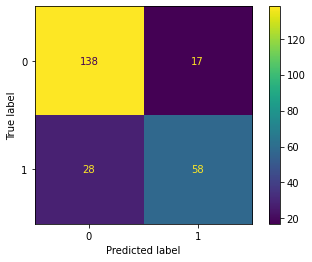

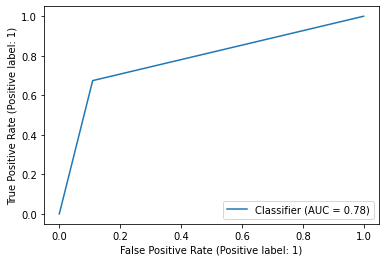

In [24]:
show_results(y_test_pred, y_test)

#### SVM

In [ ]:
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
  {"degree": [1, 2, 3, 4, 5, 6, 7, 8], 'kernel': ['poly'], 'coef0': [0, 0.3, 0.6, 1, 1.3, 1.6, 3]}
]

grid_search_estimator = GridSearchCV(SVC(), param_grid, scoring='f1')
grid_search_estimator.fit(X_train, y_train)

In [62]:
grid_search_estimator.cv_results_

{'mean_fit_time': array([1.71032906e-02, 2.29928970e-02, 5.16596699e+00, 1.40559303e+01,
        9.98568535e-03, 1.00457191e-02, 1.04995728e-02, 1.01079941e-02,
        1.39279842e-02, 9.37657356e-03, 2.35916615e-02, 2.38698959e-02,
        5.90829849e-03, 8.46571922e-03, 8.12683105e-03, 1.08945847e-02,
        1.23471737e-02, 1.35282040e-02, 1.50037289e-02, 1.53910160e-02]),
 'std_fit_time': array([9.84655227e-03, 1.15309428e-02, 1.84387292e+00, 3.11391901e+00,
        1.35030904e-04, 4.73470135e-04, 1.65501557e-03, 1.96619337e-04,
        1.63941063e-03, 2.02444831e-04, 4.04881101e-03, 2.78917688e-03,
        3.77649021e-04, 5.97202161e-04, 2.33727345e-04, 7.37966139e-04,
        2.29038905e-03, 1.46421077e-03, 1.09545867e-03, 1.08454654e-03]),
 'mean_score_time': array([0.00852599, 0.00608921, 0.00303926, 0.00348854, 0.0049438 ,
        0.0048367 , 0.00465226, 0.0054769 , 0.00400343, 0.00410008,
        0.00351229, 0.00384479, 0.00271797, 0.00276484, 0.0025075 ,
        0.00277729, 

In [19]:
model_svm = SVC(degree=8, kernel="poly")
model_svm.fit(X_train, y_train)

y_train_pred = model_svm.predict(X_train)
y_test_pred = model_svm.predict(X_test)

Accuracy:  0.8298755186721992
F1 score:  0.7602339181286549


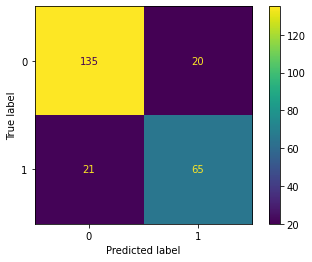

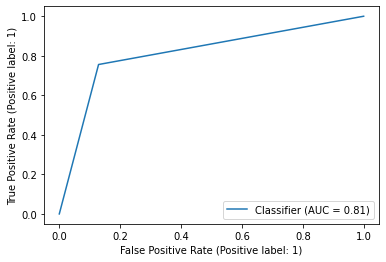

In [22]:
show_results(y_test_pred, y_test)

In [ ]:
# Plot outputs
xrange = [-2, 6]
yrange = [-2, 6]
step = 0.1
x = np.arange(xrange[0], xrange[1], step)
y = np.arange(yrange[0], yrange[1], step)
xx, yy = np.meshgrid(x, y)
z = - scipy.special.logit(model_logistic.predict_proba(np.c_[xx.reshape([-1]), yy.reshape([-1])])[:, 0].reshape(xx.shape))
plt.contourf(xx, yy, z, cmap='bwr', vmin=-20.0, vmax=20.0, levels=200)

X_new_neg = X_test[y_test==0]
X_new_pos = X_test[y_test==1]
plt.scatter(X_new_neg.values[:, 0], X_new_neg.values[:, 1],  color='blue', label='not survived')
plt.scatter(X_new_pos.values[:, 0], X_new_pos.values[:, 1],  color='red', label='survived')

plt.xlim(xrange)
plt.ylim(yrange)

plt.xlabel("Age")
plt.ylabel("Fare")

plt.legend()

plt.show()